In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
from numpy.linalg import inv
with open('data/pt1_data.pkl', 'rb') as file:
    data = pickle.load(file)
    
ground_truth = data['gt']
imu_force= data['imu_f']
imu_rot = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']


In [3]:
class Quaternion():
    def __init__(self,w=1.,x=0.,y=0.,z=0.,axis_angle=None,euler=None):
        if euler is None:
            self.w=w
            self.x=x
            self.y=y
            self.z=z

        else:
            roll=euler[0]
            pitch=euler[1]
            yaw=euler[2]
            
            cr=np.cos(roll*0.5)
            sr=np.sin(roll*0.5)
            cp=np.cos(pitch*0.5)
            sp=np.sin(pitch*0.5)
            cy=np.cos(yaw*0.5)
            sy=np.sin(yaw*0.5)
            
            self.w=cr * cp * cy + sr * sy * sp
            self.x=sr * cp * cy - cr * sp * sy
            self.y=cr * sp * cy + sr * cp * sy
            self.z=cr * cp * sy - sr * sp * cy
 
    def to_mat(self):
        q=np.array([self.x,self.y,self.z]).reshape(3,1)
        i=(self.w**2-np.dot(q.T,q))*np.identity(3)
        j=2*np.dot(q,q.T)
        k=2*self.w*skew_symmetric(q)
        return i+j+k
    def to_numpy(self):
        return np.array([self.w,self.x,self.y,self.z])
    def normalize(self):
        mag=np.linalg.norm([self.w,self.x,self.y,self.z])
        return Quaternion(self.w/mag,self.x/mag,self.y/mag,self.z/mag)
    def quat_mult_right(self,q,out='np'):
        quat=np.array([self.x,self.y,self.z]).reshape(3,1)
        s=np.zeros([4,4])
        s[0,1:]=-quat[:,0]
        s[1:,0]=quat[:,0]
        s[1:,1:]=-skew_symmetric(quat)
        sigma=self.w*np.identity(4)+s
        
        if type(q).__name__=='Quaternion':
            prod_np=np.dot(sigma,q.to_numpy())
        else:
            prod_np=np.dot(sigma,q)
        if out=='np':
            return prod_np
        elif out=='Quaternion':
            prod=Quaternion(prod_np[0],prod_np[1],prod_np[2],prod_np[3])
            return prod
    def quat_mult_left(self,q,out='np'):
        quat=np.array([self.x,self.y,self.z]).reshape(3,1)
        s=np.zeros([4,4])
        s[0,1:]=-quat[:,0]
        s[1:,0]=quat[:,0]
        s[1:,1:]=skew_symmetric(quat)
        sigma=self.w*np.identity(4)+s
        
        if type(q).__name__=='Quaternion':
            prod_np=np.dot(sigma,q.to_numpy())
        else:
            prod_np=np.dot(sigma,q)
        if out=='np':
            return prod_np
        elif out=='Quaternion':
            prod=Quaternion(prod_np[0],prod_np[1],prod_np[2],prod_np[3])
            return prod

In [4]:
def angle_normalize(a):
    #Returns angle in the range of [-pi,pi]
    return np.arctan2(np.sin(float(x)),np.cos(float(x)))
def skew_symmetric(v):

    skew=np.array([[0,  -v[2], v[1]],
                    [ v[2], 0,  -v[0]],
                    [-v[1],v[0], 0]],dtype=np.float64)
    return skew 

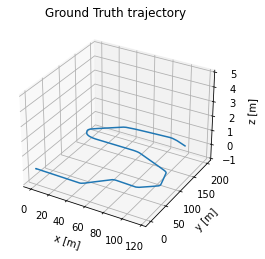

In [5]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(ground_truth.p[:,0], ground_truth.p[:,1], ground_truth.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

In [6]:
#Calibartion rotation matrix corresponding to RPY angles (0.05,0.05,0,1)
C=np.array([[ 0.99376, -0.09722,  0.05466],
            [ 0.09971,  0.99401, -0.04475],
            [-0.04998,  0.04992,  0.9975 ]])
#Translation matrix between LIDAR and IMU
trans_imu_lidar=np.array([0.5,0.1,0.5])
#Transform from the LIDAR frame to IMU frame/vehicle frame
lidar.data=(C@lidar.data.T).T+trans_imu_lidar

In [7]:
var_imu_force = 0.080
var_imu_rot = 0.00025
var_gnss  = 0.001
var_lidar = 10

gravity=np.array([0,0,-9.81]) #gravity
motion_jac=np.zeros([9,6]) #motion model noise jacobian
motion_jac[3:,:]=np.identity(6) 
meas_jac=np.zeros([3,9])
meas_jac[:,:3]=np.identity(3) #measurement model jacobian

In [8]:
position_est = np.zeros([imu_force.data.shape[0], 3])  # position estimates
velocity_est = np.zeros([imu_force.data.shape[0], 3])  # velocity estimates
quaternion_est = np.zeros([imu_force.data.shape[0], 4])  # orientation estimates as quaternions
p_covariance = np.zeros([imu_force.data.shape[0], 9, 9])  # covariance matrices at each timestep

#Set initial values
position_est[0]=ground_truth.p[0]
velocity_est[0]=ground_truth.v[0]
quaternion_est[0]=Quaternion(euler=ground_truth.r[0]).to_numpy()
p_covariance[0]=np.zeros(9)
gnss_i=0
lidar_i=0

In [9]:
def measurement_update(sensor_var,p_cov_check,y_k,p_check,v_check,q_check):
    h_k=np.zeros([3,9])
    h_k[0:3,0:3]=np.eye(3)
    
    #Compute kalman gain
    kalman_gain=p_cov_check @ h_k.T @ inv(h_k @ p_cov_check @ h_k.T + sensor_var)
    #Compute error state
    delta_x=kalman_gain@(y_k-p_check)
    #Correct predicted state
    p_hat=p_check+delta_x[0:3]
    v_hat=v_check+delta_x[3:6]
    q=Quaternion(euler = delta_x[6:9]).quat_mult_left(q_check)
    q_hat = Quaternion (*q).normalize().to_numpy()
    
    #Compute corrected covariance
    p_cov_hat=(np.identity(9)-kalman_gain@h_k)@p_cov_check
    
    return p_hat,v_hat,q_hat,p_cov_hat

In [10]:
#Defining measurement noise
l_k=np.zeros([9,6])
l_k[3:9,:]=np.identity(6)
Q=np.identity(6)
Q[0:3,0:3]*=var_imu_force
Q[3:6,3:6]*=var_imu_rot

In [11]:
#Main filter loop
for k in range(1,imu_force.data.shape[0]):
    delta_t=imu_force.t[k]-imu_force.t[k-1]
    Q_k=Q*delta_t**2
    C_ns=Quaternion(*quaternion_est[k-1]).to_mat()
    #Update with IMU Inputs
    position_est[k]=position_est[k-1]+delta_t*velocity_est[k-1]+delta_t**2*(C_ns@imu_force.data[k-1]+gravity)/2
    velocity_est[k]=velocity_est[k-1]+delta_t*(C_ns@imu_force.data[k-1]+gravity)
    q=Quaternion(euler=(imu_rot.data[k-1]*delta_t)).quat_mult_right(quaternion_est[k-1])
    quaternion_est[k]=Quaternion(*q).normalize().to_numpy()
    
    #Compute Jacobians
    F_k=np.identity(9)
    F_k[0:3,3:6]=np.identity(3)*delta_t
    F_k[3:6,6:9]=-skew_symmetric(C_ns@imu_force.data[k-1])*delta_t
    
    #Propagate uncertainity
    p_covariance[k]=F_k@p_covariance[k-1]@F_k.T+l_k@Q_k@l_k.T
    
    #Check availability of GNSS and LIDAR
    if np.any(gnss.t==imu_force.t[k]):
        t=np.where(gnss.t==imu_force.t[k])[0][0]
        [position_est[k],velocity_est[k],quaternion_est[k],p_covariance[k]]=measurement_update(np.eye(3)*var_gnss,p_covariance[k],gnss.data[t],position_est[k],velocity_est[k],quaternion_est[k])
        
    if np.any(lidar.t==imu_force.t[k]):
        t=np.where(lidar.t==imu_force.t[k])[0][0]
        [position_est[k],velocity_est[k],quaternion_est[k],p_covariance[k]]=measurement_update(np.eye(3)*var_lidar,p_covariance[k],lidar.data[t],position_est[k],velocity_est[k],quaternion_est[k])

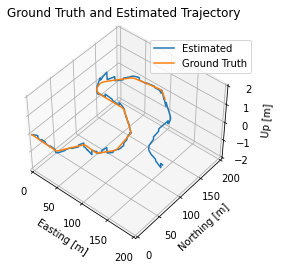

In [12]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(position_est[:,0], position_est[:,1], position_est[:,2], label='Estimated')
ax.plot(ground_truth.p[:,0], ground_truth.p[:,1], ground_truth.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()

/home/kushagra/python_proj/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


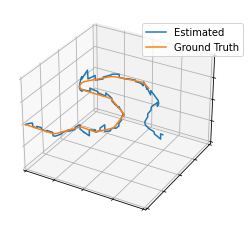

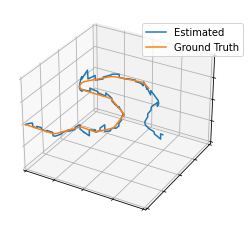

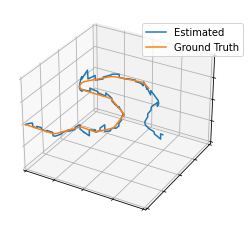

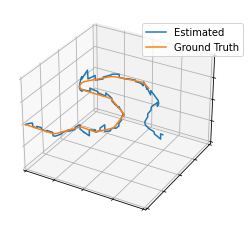

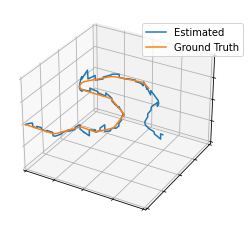

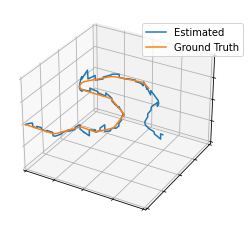

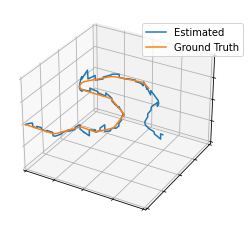

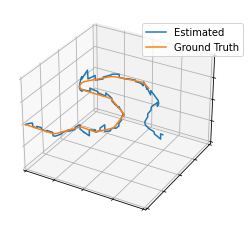

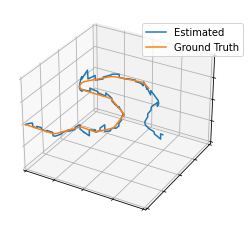

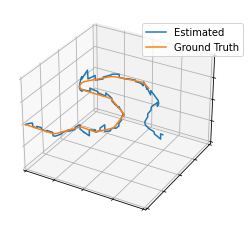

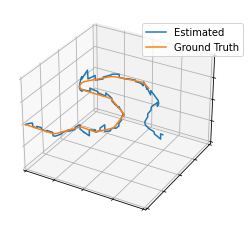

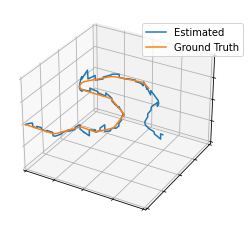

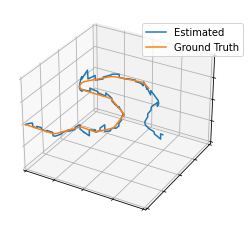

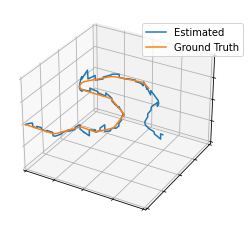

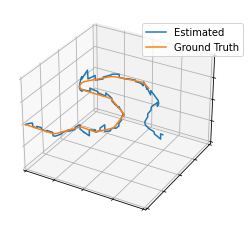

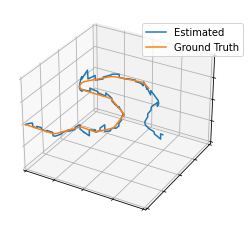

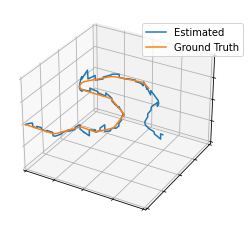

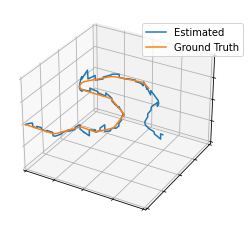

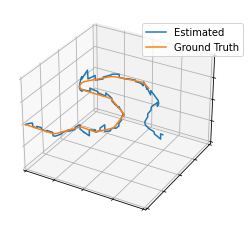

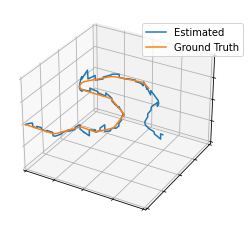

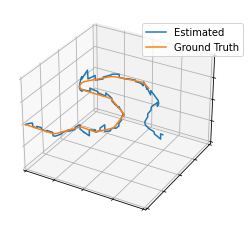

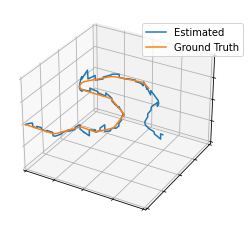

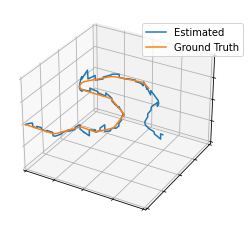

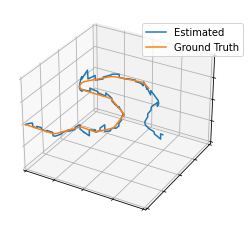

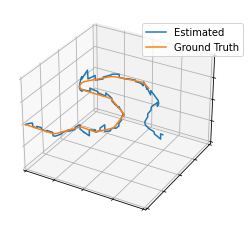

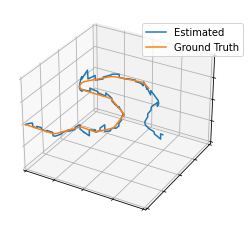

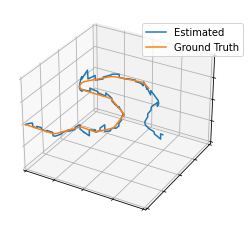

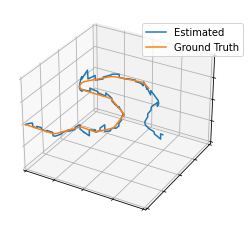

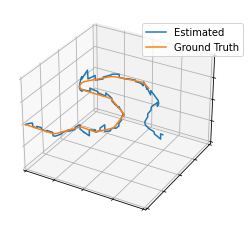

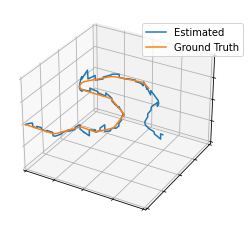

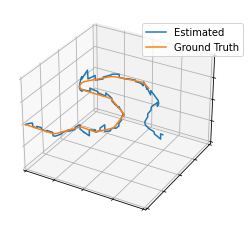

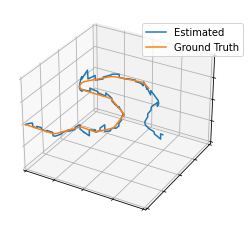

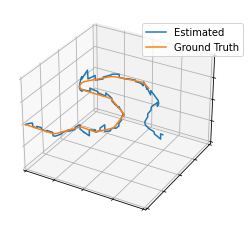

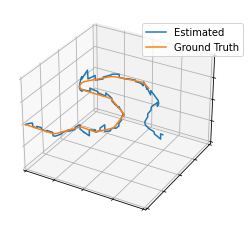

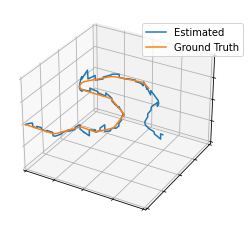

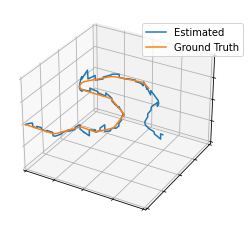

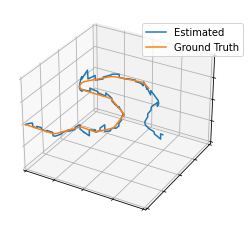

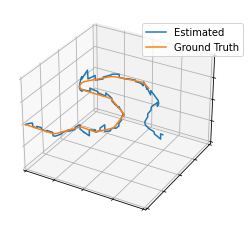

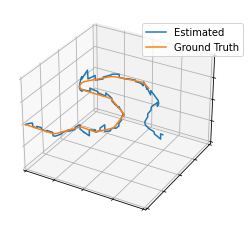

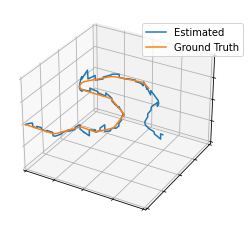

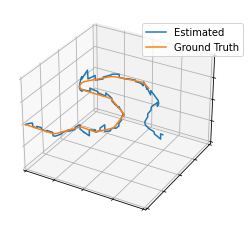

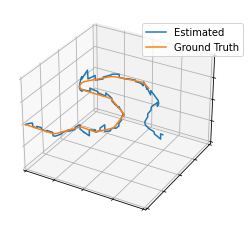

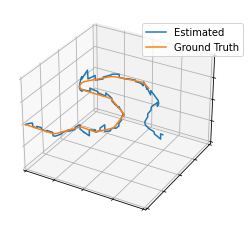

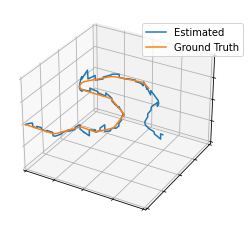

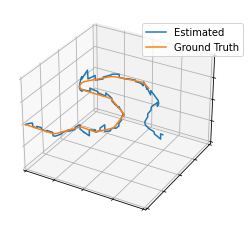

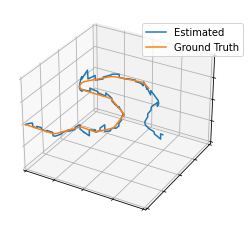

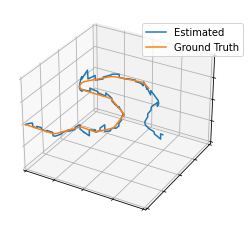

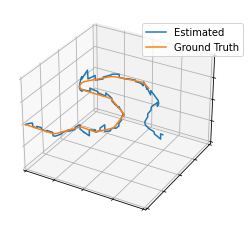

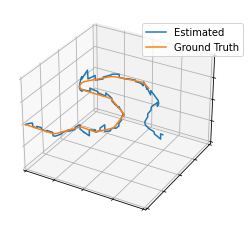

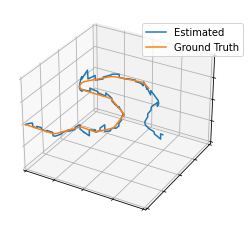

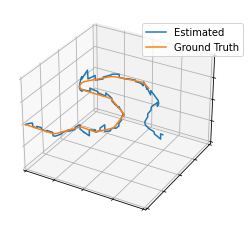

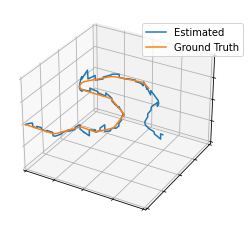

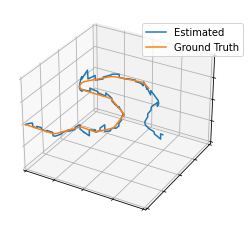

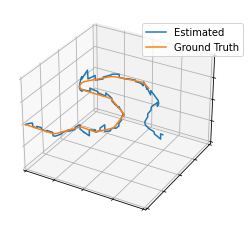

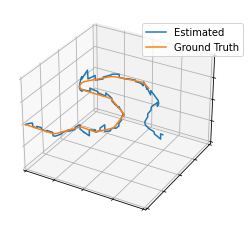

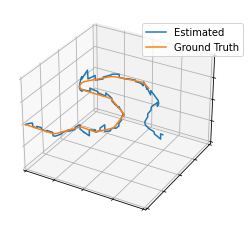

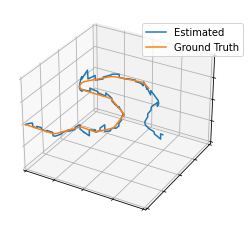

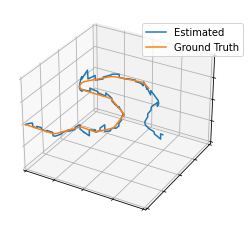

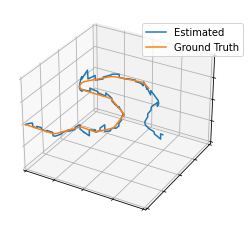

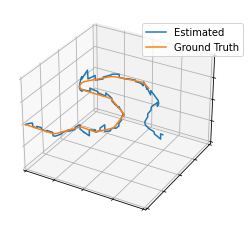

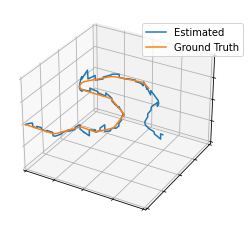

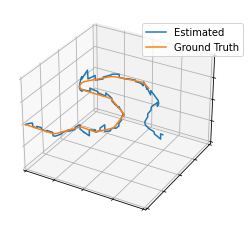

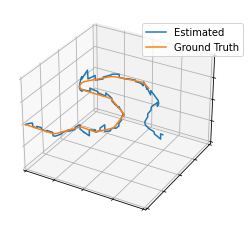

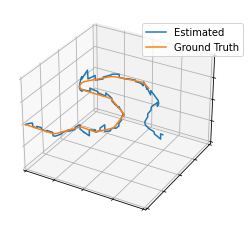

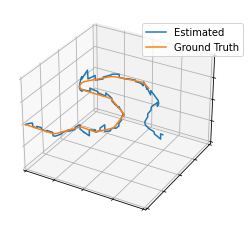

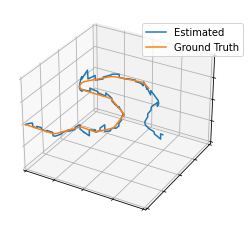

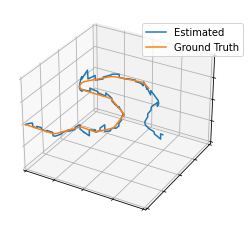

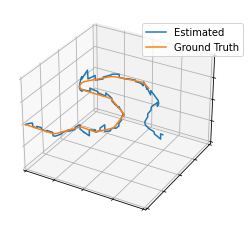

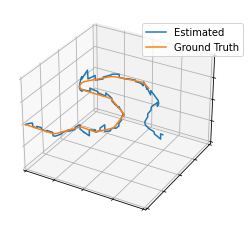

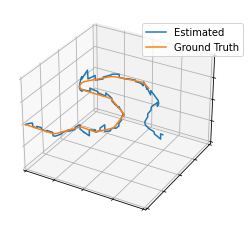

In [27]:
for angle in range(70,210,2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(position_est[:,0], position_est[:,1], position_est[:,2], label='Estimated')
    ax.plot(ground_truth.p[:,0], ground_truth.p[:,1], ground_truth.p[:,2], label='Ground Truth')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 200)
    ax.set_zlim(-2, 2)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])
    ax.view_init(30,angle)
    ax.legend(loc=(0.62,0.77))
    filename='ekf_3d'+str(angle)+'.png'
    plt.savefig(filename, dpi=96)
    plt.gca()